# Notebook sur les éléctions legislatives depuis 2017

Crée par : Sardor Niyazaliev et Cyprien Pascal

## Importation des librairies

In [2]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from folium.features import GeoJsonTooltip

## Importation des données


In [28]:
#Par département
res_2017_T1_dept = pd.read_csv("/content/result_T1_2017.csv", sep=",")
res_2017_T2_dept = pd.read_csv("/content/result_T2_2017.csv", sep=",")
res_2022_T1_dept = pd.read_csv("/content/result_T1_2022.csv", sep=",")
res_2022_T2_dept = pd.read_csv("/content/result_T2_2022.csv", sep=",")
res_2024_T1_dept = pd.read_csv("/content/result_T1_2024.csv", sep=",")
res_2024_T2_dept = pd.read_csv("/content/result_T2_2024.csv", sep=",")

#Par circoncription
res_2017_T1_circo = pd.read_csv("/content/circo_2017_T1.csv", sep=";")
res_2017_T2_circo = pd.read_csv("/content/circo_2017_T2.csv", sep=";")
res_2022_T1_circo = pd.read_csv("/content/circo_2022_T1.csv", sep=";")
res_2022_T2_circo = pd.read_csv("/content/circo_2022_T2.csv", sep=";")
res_2024_T1_circo = pd.read_csv("/content/circo_2024_T1.csv", sep=";")
res_2024_T2_circo = pd.read_csv("/content/circo_2024_T2.csv", sep=";")

#Données graph
res_2017_T2_graph = pd.read_excel("/content/Leg_2017_Resultats_T2_c.xlsx")
res_2017_T1_graph = pd.read_excel("/content/Leg_2017_Resultats_T1_c.xlsx")
res_2022_T1_graph = pd.read_excel("/content/resultats-par-niveau-dpt-t1-france-entiere_2022.xlsx")
res_2022_T2_graph = pd.read_excel("/content/resultats-par-niveau-dpt-t2-france-entiere_2022.xlsx")
res_2024_T1_graph = pd.read_excel("/content/resultats-definitifs-par-departements_T1_2024.xlsx")
res_2024_T2_graph = pd.read_excel("/content/resultats-definitifs-par-departement_T2_2024.xlsx")

#Données presidentielle
res_2017_T2_pres = pd.read_excel("/content/Presidentielle_2017_Resultats_Tour_2_c.xls")
res_2017_T1_pres = pd.read_excel("/content/resultat_2017_T1_presidentielle.xlsx")
res_2022_T1_pres = pd.read_excel("/content/resultat_2022_T1_presidentielle.xlsx")
res_2022_T2_pres = pd.read_excel("/content/resultats-par-niveau-dpt-t2-france-entiere_2022_president.xlsx")

#Nuance politique
nuance = pd.read_csv("/content/nuance_politique.csv", sep=";", encoding="ISO-8859-1")
nuance.columns = ['Nuance', 'Bord']


Analyse descriptive

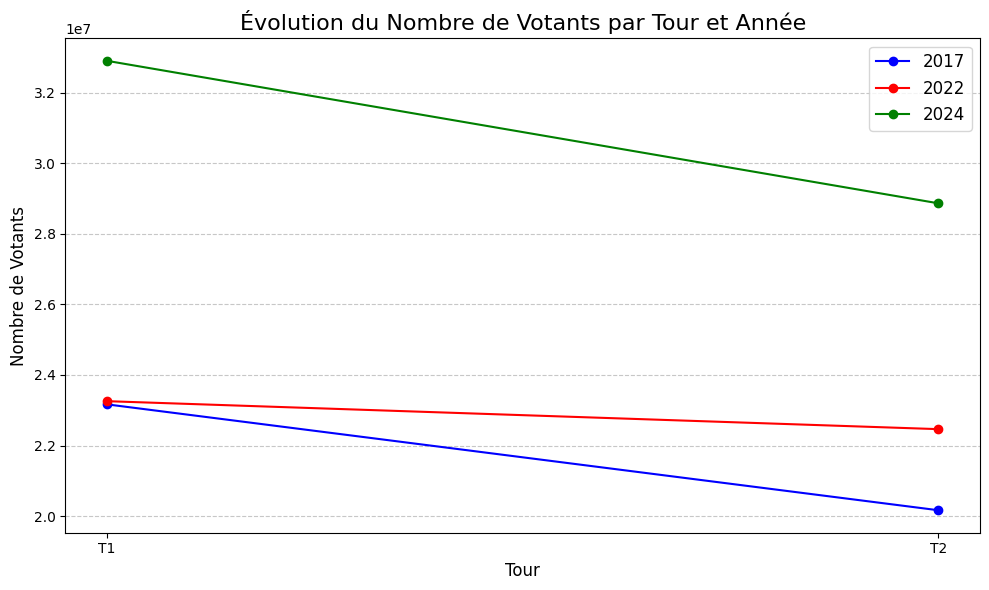

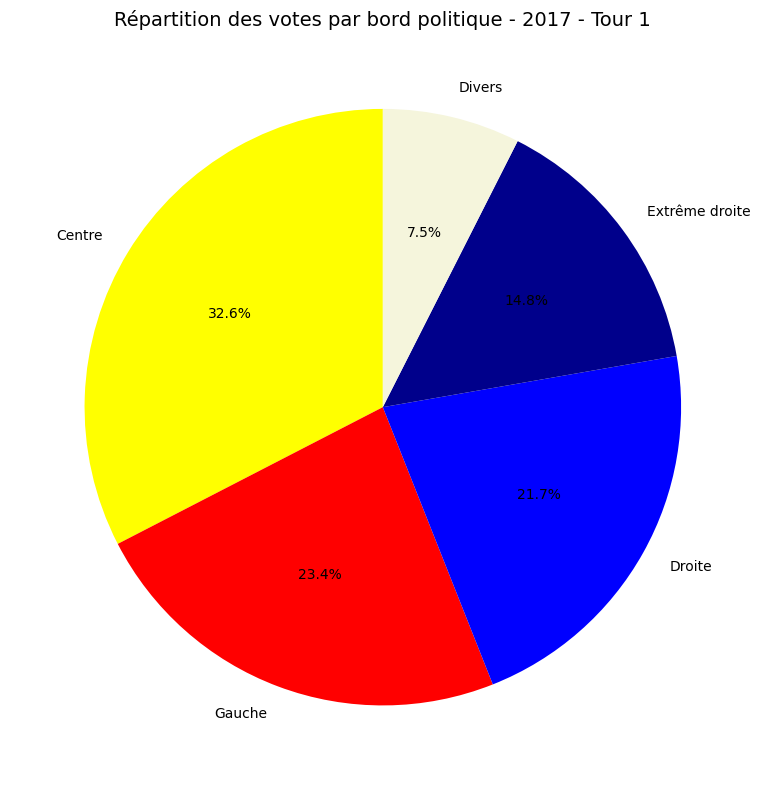

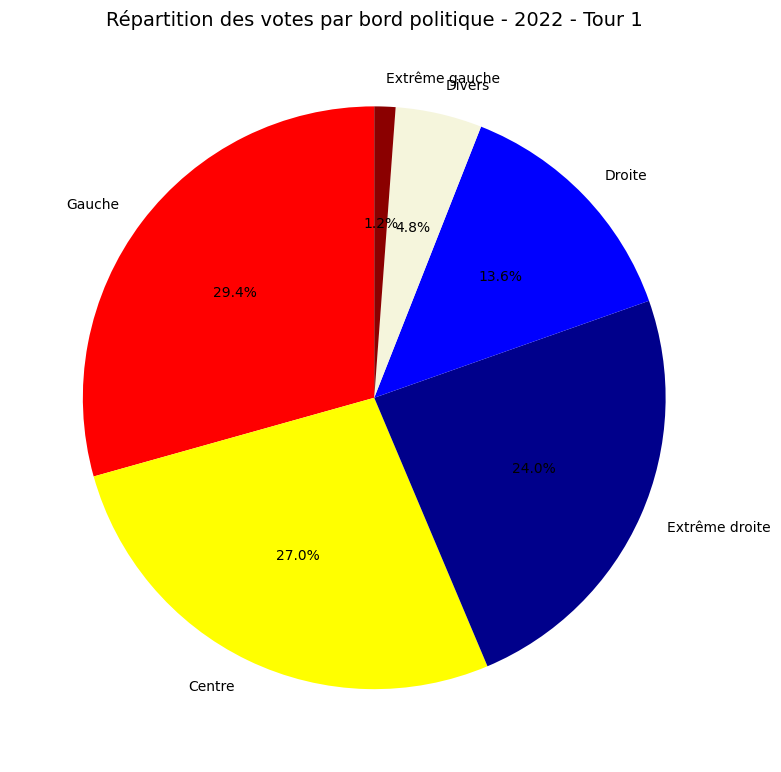

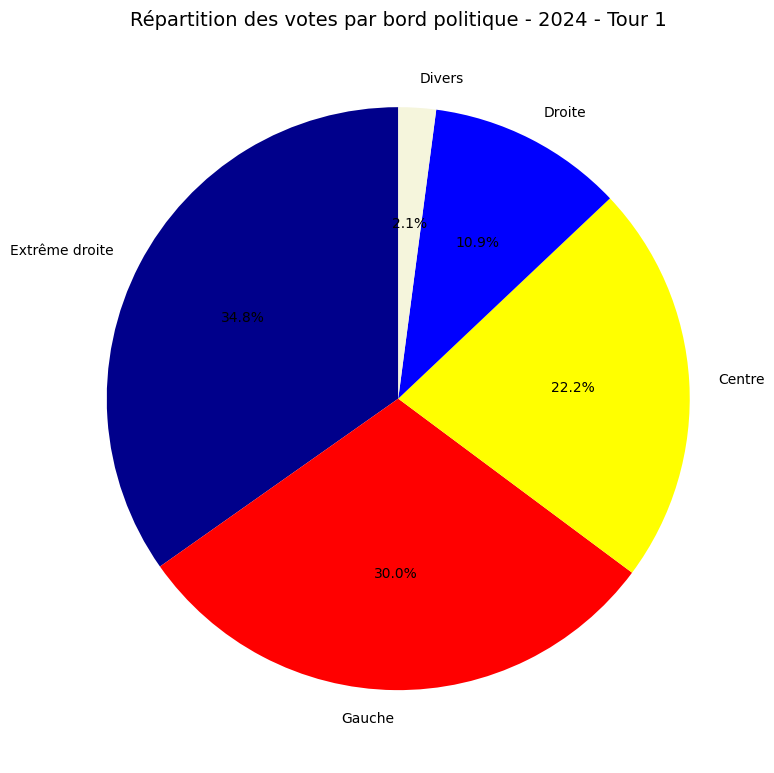

In [27]:
# Extraction du nombre total de votants
voters_2017 = [res_2017_T1_graph['Votants'].sum(), res_2017_T2_graph['Votants'].sum()]
voters_2022 = [res_2022_T1_graph['Votants'].sum(), res_2022_T2_graph['Votants'].sum()]
voters_2024 = [res_2024_T1_graph['Votants'].sum(), res_2024_T2_graph['Votants'].sum()]

# Préparation des données pour le graphique
tours = ['T1', 'T2']
years = ['2017','2022','2024']

# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(tours, voters_2017, marker='o', linestyle='-', label='2017', color='blue')
plt.plot(tours, voters_2022, marker='o', linestyle='-', label='2022', color='red')
plt.plot(tours, voters_2024, marker='o', linestyle='-', label='2024', color='green')

plt.title('Évolution du Nombre de Votants par Tour et Année', fontsize=16)
plt.xlabel('Tour', fontsize=12)
plt.ylabel('Nombre de Votants', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Affichage du graphique
plt.show()

def aggregate_votes_by_political_side(df, nuance_mapping, nuance_cols_prefix="Nuance candidat", votes_cols_prefix="Voix"):
    """
    Agrège les votes par bord politique dans un DataFrame.

    :param df: DataFrame contenant les données des candidats et des votes.
    :param nuance_mapping: Dictionnaire mappant les nuances vers les bords politiques.
    :param nuance_cols_prefix: Préfixe des colonnes contenant les nuances des candidats.
    :param votes_cols_prefix: Préfixe des colonnes contenant les votes des candidats.
    :return: Un DataFrame avec les votes totaux par bord politique.
    """
    # Identifier les colonnes de nuances et de voix utilisant startswith
    nuance_cols = [col for col in df.columns if col.startswith(nuance_cols_prefix)]
    votes_cols = [col for col in df.columns if col.startswith(votes_cols_prefix)]

    # Vérifier la correspondance entre nuances et voix
    if len(nuance_cols) != len(votes_cols):
        raise ValueError("Le nombre de colonnes de nuances et de votes ne correspond pas.")

    # Construire un DataFrame temporaire pour associer bords politiques et voix
    temp_df = pd.DataFrame({
        "Nuance": df[nuance_cols].values.flatten(),
        "Voix": df[votes_cols].values.flatten()
    })

    # Nettoyer les données
    temp_df = temp_df.dropna()
    temp_df["Nuance"] = temp_df["Nuance"].str.strip().str.upper()
    temp_df["Voix"] = temp_df["Voix"].astype(int)

    # Mapper les nuances vers les bords politiques
    temp_df["Bord"] = temp_df["Nuance"].map(nuance_mapping)

    # Supprimer les lignes sans correspondance dans le mapping
    temp_df = temp_df.dropna(subset=["Bord"])

    # Agréger les votes par bord
    aggregated_votes = temp_df.groupby("Bord")["Voix"].sum().sort_values(ascending=False)

    return aggregated_votes.reset_index()

# Nettoyer les données pour éviter les erreurs dues aux espaces ou aux majuscules dans nuance
nuance['Nuance'] = nuance['Nuance'].str.strip().str.upper()

# Mapper les nuances vers les bords
nuance_mapping = dict(zip(nuance['Nuance'], nuance['Bord']))

vote_2017_T2 = aggregate_votes_by_political_side(res_2017_T2_graph, nuance_mapping,nuance_cols_prefix="Code Nuance")
vote_2017_T1 = aggregate_votes_by_political_side(res_2017_T1_graph, nuance_mapping,nuance_cols_prefix="Code Nuance")
vote_2022_T2 = aggregate_votes_by_political_side(res_2022_T2_graph, nuance_mapping,nuance_cols_prefix="Code Nuance")
vote_2022_T1 = aggregate_votes_by_political_side(res_2022_T1_graph, nuance_mapping,nuance_cols_prefix="Code Nuance")
vote_2024_T2 = aggregate_votes_by_political_side(res_2024_T2_graph, nuance_mapping)
vote_2024_T1 = aggregate_votes_by_political_side(res_2024_T1_graph, nuance_mapping)

def plot_pie_chart_by_political_side(aggregated_votes_df, year, round):
    """
    Trace un camembert des votes par bord politique avec des couleurs spécifiques.

    :param aggregated_votes_df: DataFrame contenant les colonnes 'Bord' et 'Voix'.
    :param year: L'année de l'élection.
    :param round: Le tour de l'élection (1 ou 2).
    """
    # Couleurs en fonction des bords politiques
    def get_color(bord):
        if bord == 'Gauche':
            return 'red'
        elif bord == 'Droite':
            return 'blue'
        elif bord == 'Centre':
            return 'yellow'
        elif bord == 'Extrême droite':
            return 'darkblue'
        elif bord == 'Extrême gauche':
            return 'darkred'
        else:
            return 'beige'

    # Appliquer les couleurs aux bords
    colors = [get_color(row['Bord']) for _, row in aggregated_votes_df.iterrows()]

    # Tracer le camembert
    plt.figure(figsize=(8, 8))
    plt.pie(
        aggregated_votes_df['Voix'],
        labels=aggregated_votes_df['Bord'],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f"Répartition des votes par bord politique - {year} - Tour {round}", fontsize=14)
    plt.tight_layout()
    plt.show()

#plot_pie_chart_by_political_side(vote_2017_T2, 2017, 2)
plot_pie_chart_by_political_side(vote_2017_T1, 2017, 1)
#plot_pie_chart_by_political_side(vote_2022_T2, 2022, 2)
plot_pie_chart_by_political_side(vote_2022_T1, 2022, 1)
plot_pie_chart_by_political_side(vote_2024_T1, 2024, 1)
#plot_pie_chart_by_political_side(vote_2024_T2, 2024, 2)

# Cartes par département :

## Nettoyage en mise en forme des dataframes

In [5]:
# Suppression des colonnes pour res_2017_T1_dept et res_2017_T2_dept (colonnes 17 à 91 incluses)
res_2017_T1_dept.drop(columns=res_2017_T1_dept.columns[16:91], inplace=True)  # 16 = index 17 - 1 (0-based indexing)
res_2017_T2_dept.drop(columns=res_2017_T2_dept.columns[16:91], inplace=True)

# Suppression des colonnes pour res_2022_T1_dept et res_2022_T2_dept (colonnes 18 à 92 incluses)
res_2022_T1_dept.drop(columns=res_2022_T1_dept.columns[17:92], inplace=True)  # 17 = index 18 - 1
res_2022_T2_dept.drop(columns=res_2022_T2_dept.columns[17:92], inplace=True)


In [ ]:
# Liste des colonnes pour chaque DataFrame
columns_2017_T1 = res_2017_T1_dept.columns
columns_2017_T2 = res_2017_T2_dept.columns
columns_2022_T1 = res_2022_T1_dept.columns
columns_2022_T2 = res_2022_T2_dept.columns
columns_2024_T1 = res_2024_T1_dept.columns
columns_2024_T2 = res_2024_T2_dept.columns

# Comparaison des colonnes
columns_overview = {
    "2017_T1": list(columns_2017_T1),
    "2017_T2": list(columns_2017_T2),
    "2022_T1": list(columns_2022_T1),
    "2022_T2": list(columns_2022_T2),
    "2024_T1": list(columns_2024_T1),
    "2024_T2": list(columns_2024_T2),
}

# Affichage des colonnes
for year, columns in columns_overview.items():
    print(f"Colonnes pour {year} : {columns}")


Colonnes pour 2017_T1 : ['Code du département', 'Libellé du département', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'Code Nuance 1', 'Voix1', '% Voix/Ins 1', '% Voix/Exp 1', 'Code Nuance 2', 'Voix2', '% Voix/Ins 2', '% Voix/Exp 2', 'Code Nuance 3', 'Voix3', '% Voix/Ins 3', '% Voix/Exp 3']
Colonnes pour 2017_T2 : ['Code du département', 'Libellé du département', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'Code Nuance 1', 'Voix1', '% Voix/Ins 1', '% Voix/Exp 1', 'Code Nuance 2', 'Voix2', '% Voix/Ins 2', '% Voix/Exp 2', 'Code Nuance 3', 'Voix3', '% Voix/Ins 3', '% Voix/Exp 3']
Colonnes pour 2022_T1 : ['Code du département', 'Libellé du département', 'Etat saisie', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% V

In [6]:
# Mapping des colonnes pour uniformiser
columns_mapping = {
    'Code du département': 'Code département',
    'Libellé du département': 'Libellé département',
    '% Abs/Ins': '% Abstentions',
    '% Vot/Ins': '% Votants',
    '% Exp/Ins': '% Exprimés/inscrits',
    '% Exp/Vot': '% Exprimés/votants',
    '% Blancs/Ins': '% Blancs/inscrits',
    '% Blancs/Vot': '% Blancs/votants',
    '% Nuls/Ins': '% Nuls/inscrits',
    '% Nuls/Vot': '% Nuls/votants',
    'Code Nuance 1': 'Nuance candidat 1',
    'Code Nuance 2': 'Nuance candidat 2',
    'Code Nuance 3': 'Nuance candidat 3',
    'Voix1': 'Voix 1',
    '% Voix/Ins 1': '% Voix/inscrits 1',
    '% Voix/Exp 1': '% Voix/exprimés 1',
    'Voix2': 'Voix 2',
    '% Voix/Ins 2': '% Voix/inscrits 2',
    '% Voix/Exp 2': '% Voix/exprimés 2',
    'Voix3': 'Voix 3',
    '% Voix/Ins 3': '% Voix/inscrits 3',
    '% Voix/Exp 3': '% Voix/exprimés 3',
}

# Liste des colonnes finales dans l'ordre correct
final_columns = [
    'Code département', 'Libellé département', 'Inscrits', 'Votants', '% Votants',
    'Abstentions', '% Abstentions', 'Exprimés', '% Exprimés/inscrits', '% Exprimés/votants',
    'Blancs', '% Blancs/inscrits', '% Blancs/votants', 'Nuls', '% Nuls/inscrits', '% Nuls/votants',
    'Nuance candidat 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1',
    'Nuance candidat 2', 'Voix 2', '% Voix/inscrits 2', '% Voix/exprimés 2',
    'Nuance candidat 3', 'Voix 3', '% Voix/inscrits 3', '% Voix/exprimés 3'
]

# Fonction pour harmoniser un dataframe
def harmonize_dataframe(df):
    # Renommer les colonnes selon le mapping
    df = df.rename(columns=columns_mapping)
    # Supprimer la colonne "Etat saisie" si elle existe
    if 'Etat saisie' in df.columns:
        df = df.drop(columns=['Etat saisie'])
    # Calculer % Abstentions si elle n'existe pas explicitement
    if '% Abstentions' not in df.columns and 'Abstentions' in df.columns and 'Inscrits' in df.columns:
        df['% Abstentions'] = (df['Abstentions'] / df['Inscrits']) * 100
    # Réorganiser les colonnes selon l'ordre final
    df = df.reindex(columns=final_columns)
    return df

# Harmoniser les datasets
res_2017_T1_dept = harmonize_dataframe(res_2017_T1_dept)
res_2017_T2_dept = harmonize_dataframe(res_2017_T2_dept)
res_2022_T1_dept = harmonize_dataframe(res_2022_T1_dept)
res_2022_T2_dept = harmonize_dataframe(res_2022_T2_dept)


In [ ]:
# Liste des colonnes pour chaque DataFrame
columns_2017_T1 = res_2017_T1_dept.columns
columns_2017_T2 = res_2017_T2_dept.columns
columns_2022_T1 = res_2022_T1_dept.columns
columns_2022_T2 = res_2022_T2_dept.columns
columns_2024_T1 = res_2024_T1_dept.columns
columns_2024_T2 = res_2024_T2_dept.columns

# Comparaison des colonnes
columns_overview = {
    "2017_T1": list(columns_2017_T1),
    "2017_T2": list(columns_2017_T2),
    "2022_T1": list(columns_2022_T1),
    "2022_T2": list(columns_2022_T2),
    "2024_T1": list(columns_2024_T1),
    "2024_T2": list(columns_2024_T2),
}

# Affichage des colonnes
for year, columns in columns_overview.items():
    print(f"Colonnes pour {year} : {columns}")


Colonnes pour 2017_T1 : ['Code département', 'Libellé département', 'Inscrits', 'Votants', '% Votants', 'Abstentions', '% Abstentions', 'Exprimés', '% Exprimés/inscrits', '% Exprimés/votants', 'Blancs', '% Blancs/inscrits', '% Blancs/votants', 'Nuls', '% Nuls/inscrits', '% Nuls/votants', 'Nuance candidat 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1', 'Nuance candidat 2', 'Voix 2', '% Voix/inscrits 2', '% Voix/exprimés 2', 'Nuance candidat 3', 'Voix 3', '% Voix/inscrits 3', '% Voix/exprimés 3']
Colonnes pour 2017_T2 : ['Code département', 'Libellé département', 'Inscrits', 'Votants', '% Votants', 'Abstentions', '% Abstentions', 'Exprimés', '% Exprimés/inscrits', '% Exprimés/votants', 'Blancs', '% Blancs/inscrits', '% Blancs/votants', 'Nuls', '% Nuls/inscrits', '% Nuls/votants', 'Nuance candidat 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1', 'Nuance candidat 2', 'Voix 2', '% Voix/inscrits 2', '% Voix/exprimés 2', 'Nuance candidat 3', 'Voix 3', '% Voix/inscrits 3', '% Vo

In [7]:
# Nettoyer les données pour éviter les erreurs dues aux espaces ou aux majuscules dans nuance
nuance['Nuance'] = nuance['Nuance'].str.strip().str.upper()

# Mapper les nuances vers les bords
nuance_mapping = dict(zip(nuance['Nuance'], nuance['Bord']))

# Liste des DataFrames à traiter
dataframes = {
    "res_2017_T1_dept": res_2017_T1_dept,
    "res_2017_T2_dept": res_2017_T2_dept,
    "res_2022_T1_dept": res_2022_T1_dept,
    "res_2022_T2_dept": res_2022_T2_dept,
    "res_2024_T1_dept": res_2024_T1_dept,
    "res_2024_T2_dept": res_2024_T2_dept,
}

# Ajouter les colonnes Bord Candidat pour chaque DataFrame
for name, df in dataframes.items():
    df['Nuance candidat 1'] = df['Nuance candidat 1'].str.strip().str.upper()
    df['Nuance candidat 2'] = df['Nuance candidat 2'].str.strip().str.upper()
    df['Nuance candidat 3'] = df['Nuance candidat 3'].str.strip().str.upper()
    df['Bord Candidat 1'] = df['Nuance candidat 1'].map(nuance_mapping)
    df['Bord Candidat 2'] = df['Nuance candidat 2'].map(nuance_mapping)
    df['Bord Candidat 3'] = df['Nuance candidat 3'].map(nuance_mapping)


## Créations des cartes des résultats législatives en fonction du bord politique gagnant par tour et par année et par département depuis 2017

In [8]:
# Charger les données

# Charger la géométrie des départements français
# Limiter uniquement à la France
departments_geo = gpd.read_file(
    "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
)

def get_color(bord):
    if bord == 'Gauche':
        return 'red'
    elif bord == 'Droite':
        return 'blue'
    elif bord == 'Centre':
        return 'yellow'
    elif bord == 'Extrême droite':
        return 'darkblue'
    elif bord == 'Extrême gauche':
        return 'darkred'
    elif bord == 'Divers':
        return 'green'
    return 'gray'

def create_map(dataframe, filename):
    # Préparer les données pour le mapping
    dataframe = dataframe.merge(departments_geo[['code', 'geometry']].rename(columns={'code': 'Code département'}), on='Code département', how='left')
    dataframe['color'] = dataframe['Bord Candidat 1'].apply(get_color)

    # Créer la carte interactive limitée à la France
    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

    # Ajouter les départements à la carte
    for _, row in dataframe.iterrows():
        geojson = gpd.GeoSeries([row['geometry']]).__geo_interface__['features'][0]
        geojson['properties'] = {
            'Code département': row['Code département'],
            'Libellé département': row['Libellé département'],
            'Bord Candidat 1': row['Bord Candidat 1'],
            'Nuance candidat 1': row['Nuance candidat 1'],
            'Voix 1': row['Voix 1'],
            '% Voix/inscrits 1': row['% Voix/inscrits 1'],
            '% Voix/exprimés 1': row['% Voix/exprimés 1'],
            'Bord Candidat 2': row['Bord Candidat 2'],
            'Nuance candidat 2': row['Nuance candidat 2'],
            'Voix 2': row['Voix 2'],
            '% Voix/inscrits 2': row['% Voix/inscrits 2'],
            '% Voix/exprimés 2': row['% Voix/exprimés 2'],
            'Bord Candidat 3': row['Bord Candidat 3'],
            'Nuance candidat 3': row['Nuance candidat 3'],
            'Voix 3': row['Voix 3'],
            '% Voix/inscrits 3': row['% Voix/inscrits 3'],
            '% Voix/exprimés 3': row['% Voix/exprimés 3']
        }
        folium.GeoJson(
            geojson,
            style_function=lambda x, color=row['color']: {
                'fillColor': color,
                'color': 'black',
                'weight': 0.5,
                'fillOpacity': 0.7
            },
            tooltip=GeoJsonTooltip(
                fields=['Code département', 'Libellé département', 'Bord Candidat 1',
                        'Nuance candidat 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1',
                        'Bord Candidat 2', 'Nuance candidat 2', 'Voix 2', '% Voix/inscrits 2',
                        '% Voix/exprimés 2', 'Bord Candidat 3', 'Nuance candidat 3', 'Voix 3',
                        '% Voix/inscrits 3', '% Voix/exprimés 3'],
                aliases=['Code département:', 'Nom département:', 'Bord Candidat 1:',
                         'Nuance candidat 1:', 'Voix 1:', '% Voix/inscrits 1:',
                         '% Voix/exprimés 1:', 'Bord Candidat 2:', 'Nuance candidat 2:',
                         'Voix 2:', '% Voix/inscrits 2:', '% Voix/exprimés 2:',
                         'Bord Candidat 3:', 'Nuance candidat 3:', 'Voix 3:',
                         '% Voix/inscrits 3:', '% Voix/exprimés 3:'],
                localize=True,
                sticky=True,
                labels=True
            ),
            highlight_function=lambda x: {
                'weight': 3,
                'color': 'black',
                'fillOpacity': 1
            }
        ).add_to(m)

    # Ajouter une légende
    legend_html = """
    <div style="position: fixed;
                bottom: 50px; left: 50px; width: 120px; height: 150px;
                background-color: white; z-index:9999; font-size:14px;">
        <b>Légende</b><br>
        <i style="background: red; width: 10px; height: 10px; display: inline-block;"></i> Gauche<br>
        <i style="background: darkred; width: 10px; height: 10px; display: inline-block;"></i> Extrême Gauche<br>
        <i style="background: blue; width: 10px; height: 10px; display: inline-block;"></i> Droite<br>
        <i style="background: yellow; width: 10px; height: 10px; display: inline-block;"></i> Centre<br>
        <i style="background: darkblue; width: 10px; height: 10px; display: inline-block;"></i> Extrême Droite<br>
        <i style="background: green; width: 10px; height: 10px; display: inline-block;"></i> Divers<br>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    # Sauvegarder la carte en HTML
    m.save(f"{filename}.html")

# Liste des DataFrames et des noms de fichiers correspondants
dataframes = {
    "res_2017_T1_dept": res_2017_T1_dept,
    "res_2017_T2_dept": res_2017_T2_dept,
    "res_2022_T1_dept": res_2022_T1_dept,
    "res_2022_T2_dept": res_2022_T2_dept,
    "res_2024_T1_dept": res_2024_T1_dept,
    "res_2024_T2_dept": res_2024_T2_dept,
}

# Normaliser les codes des départements pour tous les DataFrames
for name, df in dataframes.items():
    df["Code département"] = df["Code département"].apply(lambda x: f"{int(x):02}" if x.isdigit() else x)

# Générer les cartes pour chaque DataFrame
for name, df in dataframes.items():
    create_map(df, name)

print("Toutes les cartes interactives ont été générées et sauvegardées.")


Toutes les cartes interactives ont été générées et sauvegardées.


# Cartes par circonscription

## Aperçu des colonnes pour chaque année

In [9]:
# Liste des colonnes pour chaque DataFrame
columns_2017_T1 = res_2017_T1_circo.columns
columns_2017_T2 = res_2017_T2_circo.columns
columns_2022_T1 = res_2022_T1_circo.columns
columns_2022_T2 = res_2022_T2_circo.columns
columns_2024_T1 = res_2024_T1_circo.columns
columns_2024_T2 = res_2024_T2_circo.columns

# Comparaison des colonnes
columns_overview = {
    "2017_T1": list(columns_2017_T1),
    "2017_T2": list(columns_2017_T2),
    "2022_T1": list(columns_2022_T1),
    "2022_T2": list(columns_2022_T2),
    "2024_T1": list(columns_2024_T1),
    "2024_T2": list(columns_2024_T2),
}

# Affichage des colonnes
for year, columns in columns_overview.items():
    print(f"Colonnes pour {year} : {columns}")


Colonnes pour 2017_T1 : ['Code du département', 'Libellé du département', 'Code de la circonscription', 'Libellé de la circonscription', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau', 'Sexe', 'Nom', 'Prénom', 'Nuance', 'Voix', '% Voix/Ins', '% Voix/Exp', 'Sièges', 'N°Panneau.1', 'Sexe.1', 'Nom.1', 'Prénom.1', 'Nuance.1', 'Voix.1', '% Voix/Ins.1', '% Voix/Exp.1', 'Sièges.1', 'N°Panneau.2', 'Sexe.2', 'Nom.2', 'Prénom.2', 'Nuance.2', 'Voix.2', '% Voix/Ins.2', '% Voix/Exp.2', 'Sièges.2', 'N°Panneau.3', 'Sexe.3', 'Nom.3', 'Prénom.3', 'Nuance.3', 'Voix.3', '% Voix/Ins.3', '% Voix/Exp.3', 'Sièges.3', 'N°Panneau.4', 'Sexe.4', 'Nom.4', 'Prénom.4', 'Nuance.4', 'Voix.4', '% Voix/Ins.4', '% Voix/Exp.4', 'Sièges.4', 'N°Panneau.5', 'Sexe.5', 'Nom.5', 'Prénom.5', 'Nuance.5', 'Voix.5', '% Voix/Ins.5', '% Voix/Exp.5', 'Sièges.5', 'N°Panneau.6', 'Sexe.6', 'Nom

## Uniformisation de 2017

In [10]:
import pandas as pd

# Liste des colonnes des candidats (modifie si nécessaire)
candidate_columns = [
    'N°Panneau', 'Sexe', 'Nom', 'Prénom', 'Nuance', 'Voix',
    '% Voix/Ins', '% Voix/Exp', 'Sièges'
]

# Processus pour extraire le top 2 par ligne et réduire les DataFrames
for df_name in ['res_2017_T1_circo', 'res_2017_T2_circo']:
    df = globals()[df_name]
    top_1_data = []
    top_2_data = []

    for index, row in df.iterrows():
        # Récupération des colonnes des voix des candidats
        voix_columns = ['Voix'] + [f'Voix.{i}' for i in range(1, 27)]
        voix_values = [row[col] for col in voix_columns if col in df.columns]

        # Index des deux meilleurs candidats
        sorted_indices = sorted(range(len(voix_values)), key=lambda x: voix_values[x], reverse=True)
        top_1_idx = sorted_indices[0]
        top_2_idx = sorted_indices[1]

        # Extraction des informations des deux meilleurs candidats
        top_1_data.append({
            f'{col}.1': row[f'{col}' if top_1_idx == 0 else f'{col}.{top_1_idx}']
            for col in candidate_columns
        })
        top_2_data.append({
            f'{col}.2': row[f'{col}' if top_2_idx == 0 else f'{col}.{top_2_idx}']
            for col in candidate_columns
        })

    # Ajout des colonnes au DataFrame
    for col in candidate_columns:
        df[f'{col}.1'] = [data[f'{col}.1'] for data in top_1_data]
        df[f'{col}.2'] = [data[f'{col}.2'] for data in top_2_data]

    # Conserver uniquement les colonnes des 2 meilleurs candidats et les informations de circonscription
    keep_columns = [
        'Code du département', 'Libellé du département',
        'Code de la circonscription', 'Libellé de la circonscription',
        'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
        'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot',
        'Exprimés', '% Exp/Ins', '% Exp/Vot'
    ] + [f'{col}.1' for col in candidate_columns] + [f'{col}.2' for col in candidate_columns]

    globals()[df_name] = df[keep_columns]


In [11]:
# Ajout d'un 0 devant les numéros de département de 1 à 9 uniquement s'il manque
for df_name in ['res_2017_T1_circo', 'res_2017_T2_circo']:
    df = globals()[df_name]
    df['Code du département'] = df['Code du département'].apply(lambda x: str(x).zfill(2) if len(str(x)) == 1 else str(x))
    globals()[df_name] = df


<ipython-input-11-348821e66345>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Code du département'] = df['Code du département'].apply(lambda x: str(x).zfill(2) if len(str(x)) == 1 else str(x))


## Uniformisation de 2022

In [12]:
# Suppression de la colonne 'Etat saisie' et extraction des top 2 candidats
for df_name in ['res_2022_T1_circo', 'res_2022_T2_circo']:
    df = globals()[df_name]

    # Suppression de la colonne 'Etat saisie'
    if 'Etat saisie' in df.columns:
        df = df.drop(columns=['Etat saisie'])

    # Extraction des deux meilleurs candidats
    top_1_data = []
    top_2_data = []

    for index, row in df.iterrows():
        # Récupération des colonnes des voix
        voix_columns = ['Voix'] + [f'Voix.{i}' for i in range(1, 19)]
        voix_values = [row[col] for col in voix_columns if col in df.columns]

        # Index des deux meilleurs candidats
        sorted_indices = sorted(range(len(voix_values)), key=lambda x: voix_values[x], reverse=True)
        top_1_idx = sorted_indices[0]
        top_2_idx = sorted_indices[1]

        # Extraction des informations des deux meilleurs candidats
        candidate_columns = ['N°Panneau', 'Sexe', 'Nom', 'Prénom', 'Nuance', 'Voix', '% Voix/Ins', '% Voix/Exp', 'Sièges']
        top_1_data.append({
            f'{col}.1': row[f'{col}' if top_1_idx == 0 else f'{col}.{top_1_idx}']
            for col in candidate_columns
        })
        top_2_data.append({
            f'{col}.2': row[f'{col}' if top_2_idx == 0 else f'{col}.{top_2_idx}']
            for col in candidate_columns
        })

    # Ajout des colonnes des deux meilleurs candidats au DataFrame
    for col in candidate_columns:
        df[f'{col}.1'] = [data[f'{col}.1'] for data in top_1_data]
        df[f'{col}.2'] = [data[f'{col}.2'] for data in top_2_data]

    # Filtrer les colonnes finales
    keep_columns = [
        'Code du département', 'Libellé du département',
        'Code de la circonscription', 'Libellé de la circonscription',
        'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins',
        'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot',
        'Exprimés', '% Exp/Ins', '% Exp/Vot'
    ] + [f'{col}.1' for col in candidate_columns] + [f'{col}.2' for col in candidate_columns]

    # Mise à jour du DataFrame global
    globals()[df_name] = df[keep_columns]


In [13]:
# Ajout d'un 0 devant les numéros de département de 1 à 9 uniquement s'il manque
for df_name in ['res_2022_T1_circo', 'res_2022_T2_circo']:
    df = globals()[df_name]
    df['Code du département'] = df['Code du département'].apply(lambda x: str(x).zfill(2) if len(str(x)) == 1 else str(x))
    globals()[df_name] = df


<ipython-input-13-d04dc0b4f493>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Code du département'] = df['Code du département'].apply(lambda x: str(x).zfill(2) if len(str(x)) == 1 else str(x))


## Uniformisation 2024

In [14]:
# Extraction des top 2 candidats pour les élections 2024
for df_name in ['res_2024_T1_circo', 'res_2024_T2_circo']:
    df = globals()[df_name]

    # Extraction des deux meilleurs candidats
    top_1_data = []
    top_2_data = []

    for index, row in df.iterrows():
        # Récupération des colonnes des voix
        voix_columns = [f'Voix {i}' for i in range(1, 20)]
        voix_values = [row[col] for col in voix_columns if col in df.columns]

        # Index des deux meilleurs candidats
        sorted_indices = sorted(range(len(voix_values)), key=lambda x: voix_values[x], reverse=True)
        top_1_idx = sorted_indices[0]
        top_2_idx = sorted_indices[1]

        # Extraction des informations des deux meilleurs candidats
        candidate_columns = ['Numéro de panneau', 'Nuance candidat', 'Nom candidat', 'Prénom candidat', 'Sexe candidat', 'Voix', '% Voix/inscrits', '% Voix/exprimés', 'Elu']
        top_1_data.append({
            f'{col} 1': row[f'{col} {top_1_idx + 1}']
            for col in candidate_columns
        })
        top_2_data.append({
            f'{col} 2': row[f'{col} {top_2_idx + 1}']
            for col in candidate_columns
        })

    # Ajout des colonnes des deux meilleurs candidats au DataFrame
    for col in candidate_columns:
        df[f'{col} 1'] = [data[f'{col} 1'] for data in top_1_data]
        df[f'{col} 2'] = [data[f'{col} 2'] for data in top_2_data]

    # Filtrer les colonnes finales
    keep_columns = [
        'Code département', 'Libellé département',
        'Code circonscription législative', 'Libellé circonscription législative',
        'Inscrits', 'Votants', '% Votants', 'Abstentions', '% Abstentions',
        'Exprimés', '% Exprimés/inscrits', '% Exprimés/votants',
        'Blancs', '% Blancs/inscrits', '% Blancs/votants',
        'Nuls', '% Nuls/inscrits', '% Nuls/votants'
    ] + [f'{col} 1' for col in candidate_columns] + [f'{col} 2' for col in candidate_columns]

    # Mise à jour du DataFrame global
    globals()[df_name] = df[keep_columns]


In [15]:
# Ajout d'un 0 devant les numéros de département de 1 à 9 uniquement s'il manque
for df_name in ['res_2024_T1_circo', 'res_2024_T2_circo']:
    df = globals()[df_name]
    df['Code département'] = df['Code département'].apply(lambda x: str(x).zfill(2) if len(str(x)) == 1 else str(x))
    globals()[df_name] = df


<ipython-input-15-865c9fe0536a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Code département'] = df['Code département'].apply(lambda x: str(x).zfill(2) if len(str(x)) == 1 else str(x))


## Uniformisation des trois dataframes

In [16]:
# Liste des colonnes pour chaque DataFrame
columns_2017_T1 = res_2017_T1_circo.columns
columns_2017_T2 = res_2017_T2_circo.columns
columns_2022_T1 = res_2022_T1_circo.columns
columns_2022_T2 = res_2022_T2_circo.columns
columns_2024_T1 = res_2024_T1_circo.columns
columns_2024_T2 = res_2024_T2_circo.columns

# Comparaison des colonnes
columns_overview = {
    "2017_T1": list(columns_2017_T1),
    "2017_T2": list(columns_2017_T2),
    "2022_T1": list(columns_2022_T1),
    "2022_T2": list(columns_2022_T2),
    "2024_T1": list(columns_2024_T1),
    "2024_T2": list(columns_2024_T2),
}

# Affichage des colonnes
for year, columns in columns_overview.items():
    print(f"Colonnes pour {year} : {columns}")


Colonnes pour 2017_T1 : ['Code du département', 'Libellé du département', 'Code de la circonscription', 'Libellé de la circonscription', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau.1', 'Sexe.1', 'Nom.1', 'Prénom.1', 'Nuance.1', 'Voix.1', '% Voix/Ins.1', '% Voix/Exp.1', 'Sièges.1', 'N°Panneau.2', 'Sexe.2', 'Nom.2', 'Prénom.2', 'Nuance.2', 'Voix.2', '% Voix/Ins.2', '% Voix/Exp.2', 'Sièges.2']
Colonnes pour 2017_T2 : ['Code du département', 'Libellé du département', 'Code de la circonscription', 'Libellé de la circonscription', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot', 'N°Panneau.1', 'Sexe.1', 'Nom.1', 'Prénom.1', 'Nuance.1', 'Voix.1', '% Voix/Ins.1', '% Voix/Exp.1', 'Sièges.1', 'N°Panneau.2', 'Sexe.2', 'Nom.

In [17]:
# Mapping des colonnes des DataFrames vers la structure 2024
column_mapping = {
    'Code du département': 'Code département',
    'Libellé du département': 'Libellé département',
    'Code de la circonscription': 'Code circonscription législative',
    'Libellé de la circonscription': 'Libellé circonscription législative',
    '% Abs/Ins': '% Abstentions',
    '% Vot/Ins': '% Votants',
    '% Exp/Ins': '% Exprimés/inscrits',
    '% Exp/Vot': '% Exprimés/votants',
    '% Blancs/Ins': '% Blancs/inscrits',
    '% Blancs/Vot': '% Blancs/votants',
    '% Nuls/Ins': '% Nuls/inscrits',
    '% Nuls/Vot': '% Nuls/votants',
    'N°Panneau.1': 'Numéro de panneau 1',
    'Nuance.1': 'Nuance candidat 1',
    'Nom.1': 'Nom candidat 1',
    'Prénom.1': 'Prénom candidat 1',
    'Sexe.1': 'Sexe candidat 1',
    'Voix.1': 'Voix 1',
    '% Voix/Ins.1': '% Voix/inscrits 1',
    '% Voix/Exp.1': '% Voix/exprimés 1',
    'N°Panneau.2': 'Numéro de panneau 2',
    'Nuance.2': 'Nuance candidat 2',
    'Nom.2': 'Nom candidat 2',
    'Prénom.2': 'Prénom candidat 2',
    'Sexe.2': 'Sexe candidat 2',
    'Voix.2': 'Voix 2',
    '% Voix/Ins.2': '% Voix/inscrits 2',
    '% Voix/Exp.2': '% Voix/exprimés 2'
}

# Colonnes à conserver absolument
essential_columns = ['Inscrits', 'Votants', 'Abstentions', 'Exprimés', 'Blancs', 'Nuls']

# Ordre des colonnes souhaité
final_column_order = [
    'Code département', 'Libellé département', 'Code circonscription législative',
    'Libellé circonscription législative', '% Votants', '% Abstentions',
    '% Exprimés/inscrits', '% Exprimés/votants', '% Blancs/inscrits', '% Blancs/votants',
    '% Nuls/inscrits', '% Nuls/votants', 'Numéro de panneau 1', 'Sexe candidat 1',
    'Nom candidat 1', 'Prénom candidat 1', 'Nuance candidat 1', 'Voix 1',
    '% Voix/inscrits 1', '% Voix/exprimés 1', 'Numéro de panneau 2', 'Sexe candidat 2',
    'Nom candidat 2', 'Prénom candidat 2', 'Nuance candidat 2', 'Voix 2',
    '% Voix/inscrits 2', '% Voix/exprimés 2'
]

# DataFrames à traiter avec les nouveaux noms
dataframes = ['res_2017_T1_circo', 'res_2017_T2_circo', 'res_2022_T1_circo', 'res_2022_T2_circo', 'res_2024_T1_circo', 'res_2024_T2_circo']

for df_name in dataframes:
    df = globals()[df_name]

    # Renommer les colonnes selon le mapping
    df = df.rename(columns=column_mapping)

    # Identifier les colonnes non mappées qui ne sont pas essentielles
    unmapped_columns = [
        col for col in df.columns
        if col not in column_mapping.values() and col not in essential_columns
    ]

    # Supprimer les colonnes non essentielles
    if unmapped_columns:
        print(f"Colonnes supprimées pour {df_name}: {unmapped_columns}")
        df = df.drop(columns=unmapped_columns)

    # Réorganiser les colonnes selon l'ordre final
    df = df[[col for col in final_column_order if col in df.columns]]

    # Mise à jour du DataFrame global
    globals()[df_name] = df


Colonnes supprimées pour res_2017_T1_circo: ['Sièges.1', 'Sièges.2']
Colonnes supprimées pour res_2017_T2_circo: ['Sièges.1', 'Sièges.2']
Colonnes supprimées pour res_2022_T1_circo: ['Sièges.1', 'Sièges.2']
Colonnes supprimées pour res_2022_T2_circo: ['Sièges.1', 'Sièges.2']
Colonnes supprimées pour res_2024_T1_circo: ['Elu 1', 'Elu 2']
Colonnes supprimées pour res_2024_T2_circo: ['Elu 1', 'Elu 2']


In [18]:
# Nettoyer les données pour éviter les erreurs dues aux espaces ou aux majuscules dans nuance
nuance['Nuance'] = nuance['Nuance'].str.strip().str.upper()

# Mapper les nuances vers les bords
nuance_mapping = dict(zip(nuance['Nuance'], nuance['Bord']))

# Liste des DataFrames à traiter avec les nouveaux noms
dataframes = {
    "res_2017_T1_circo": res_2017_T1_circo,
    "res_2017_T2_circo": res_2017_T2_circo,
    "res_2022_T1_circo": res_2022_T1_circo,
    "res_2022_T2_circo": res_2022_T2_circo,
    "res_2024_T1_circo": res_2024_T1_circo,
    "res_2024_T2_circo": res_2024_T2_circo,
}
# Ajouter les colonnes Bord Candidat pour chaque DataFrame
for name, df in dataframes.items():
    df['Nuance candidat 1'] = df['Nuance candidat 1'].str.strip().str.upper()
    df['Nuance candidat 2'] = df['Nuance candidat 2'].str.strip().str.upper()
    df['Bord Candidat 1'] = df['Nuance candidat 1'].map(nuance_mapping)
    df['Bord Candidat 2'] = df['Nuance candidat 2'].map(nuance_mapping)


In [19]:
# Modifier le format du code circonscription législative pour 2017 et 2022 sans fonction
# Ajouter un zéro pour les codes circo entre 1 et 9 et préfixer avec le code département

for df_name in ['res_2017_T1_circo', 'res_2017_T2_circo', 'res_2022_T1_circo', 'res_2022_T2_circo']:
    df = globals()[df_name]
    df['Code circonscription législative'] = (
        df['Code département'].astype(str).str.zfill(2) +
        df['Code circonscription législative'].astype(str).str.zfill(2)
    )


In [20]:
# Vérifier et corriger la longueur de 'Code circonscription législative' pour les 6 DataFrames
# Si la taille est de 3, ajouter un zéro devant

for df_name in ['res_2017_T1_circo', 'res_2017_T2_circo', 'res_2022_T1_circo', 'res_2022_T2_circo', 'res_2024_T1_circo', 'res_2024_T2_circo']:
    df = globals()[df_name]
    df['Code circonscription législative'] = df['Code circonscription législative'].astype(str)

    # Ajouter un zéro devant si la longueur est de 3
    df.loc[df['Code circonscription législative'].str.len() == 3, 'Code circonscription législative'] = (
        df['Code circonscription législative'].str.zfill(4)
    )

print("La longueur des codes de circonscription a été vérifiée et corrigée si nécessaire pour les 6 DataFrames.")


La longueur des codes de circonscription a été vérifiée et corrigée si nécessaire pour les 6 DataFrames.


## Créations des cartes des résultats législatives en fonction du bord politique gagnant par tour et par année et par circoncription depuis 2017

In [22]:
circonscriptions_geo = gpd.read_file("/content/circonscriptions-legislatives-p20.geojson")

def get_color(bord):
    if bord == 'Gauche':
        return 'red'
    elif bord == 'Droite':
        return 'blue'
    elif bord == 'Centre':
        return 'yellow'
    elif bord == 'Extrême droite':
        return 'darkblue'
    elif bord == 'Extrême gauche':
        return 'darkred'
    elif bord == 'Divers':
        return 'green'
    return 'gray'

def create_map(dataframe, filename):
    dataframe = dataframe.merge(
        circonscriptions_geo[['codeCirconscription', 'geometry']].rename(columns={'codeCirconscription': 'Code circonscription législative'}),
        on='Code circonscription législative',
        how='left'
    )
    dataframe['color'] = dataframe['Bord Candidat 1'].apply(get_color)

    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

    for _, row in dataframe.iterrows():
        geojson = gpd.GeoSeries([row['geometry']]).__geo_interface__['features'][0]
        geojson['properties'] = {
            'Code circonscription': row['Code circonscription législative'],
            'Libellé circonscription': row['Libellé circonscription législative'],
            'Bord Candidat 1': row['Bord Candidat 1'],
            'Nuance candidat 1': row['Nuance candidat 1'],
            'Voix 1': row['Voix 1'],
            '% Voix/inscrits 1': row['% Voix/inscrits 1'],
            '% Voix/exprimés 1': row['% Voix/exprimés 1'],
            'Bord Candidat 2': row['Bord Candidat 2'],
            'Nuance candidat 2': row['Nuance candidat 2'],
            'Voix 2': row['Voix 2'],
            '% Voix/inscrits 2': row['% Voix/inscrits 2'],
            '% Voix/exprimés 2': row['% Voix/exprimés 2'],
        }
        folium.GeoJson(
            geojson,
            style_function=lambda x, color=row['color']: {
                'fillColor': color,
                'color': 'black',
                'weight': 0.5,
                'fillOpacity': 0.7
            },
            tooltip=GeoJsonTooltip(
                fields=['Code circonscription', 'Libellé circonscription', 'Bord Candidat 1',
                        'Nuance candidat 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1',
                        'Bord Candidat 2', 'Nuance candidat 2', 'Voix 2', '% Voix/inscrits 2',
                        '% Voix/exprimés 2'],
                aliases=['Code circonscription:', 'Libellé circonscription:', 'Bord Candidat 1:',
                         'Nuance candidat 1:', 'Voix 1:', '% Voix/inscrits 1:',
                         '% Voix/exprimés 1:', 'Bord Candidat 2:', 'Nuance candidat 2:',
                         'Voix 2:', '% Voix/inscrits 2:', '% Voix/exprimés 2:'],
                localize=True,
                sticky=True,
                labels=True
            ),
            highlight_function=lambda x: {
                'weight': 3,
                'color': 'black',
                'fillOpacity': 1
            }
        ).add_to(m)

    legend_html = """
    <div style="position: fixed;
                bottom: 50px; left: 50px; width: 120px; height: 150px;
                background-color: white; z-index:9999; font-size:14px;">
        <b>Légende</b><br>
        <i style="background: red; width: 10px; height: 10px; display: inline-block;"></i> Gauche<br>
        <i style="background: darkred; width: 10px; height: 10px; display: inline-block;"></i> Extrême Gauche<br>
        <i style="background: blue; width: 10px; height: 10px; display: inline-block;"></i> Droite<br>
        <i style="background: yellow; width: 10px; height: 10px; display: inline-block;"></i> Centre<br>
        <i style="background: darkblue; width: 10px; height: 10px; display: inline-block;"></i> Extrême Droite<br>
        <i style="background: green; width: 10px; height: 10px; display: inline-block;"></i> Divers<br>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))
    m.save(f"{filename}_circo.html")

dataframes = {
    "res_2017_T1_circo": res_2017_T1_circo,
    "res_2017_T2_circo": res_2017_T2_circo,
    "res_2022_T1_circo": res_2022_T1_circo,
    "res_2022_T2_circo": res_2022_T2_circo,
    "res_2024_T1_circo": res_2024_T1_circo,
    "res_2024_T2_circo": res_2024_T2_circo,
}

for name, df in dataframes.items():
    create_map(df, name)

print("Cartes générées.")


Cartes générées.


Carte présidentielle

Traitement des données

In [29]:
# Mapping des colonnes pour uniformiser
columns_mapping = {
    'Code du département': 'Code département',
    'Libellé du département': 'Libellé département',
    '% Abs/Ins': '% Abstentions',
    '% Vot/Ins': '% Votants',  # Correction ajoutée
    '% Exp/Ins': '% Exprimés/inscrits',
    '% Exp/Vot': '% Exprimés/votants',
    '% Blancs/Ins': '% Blancs/inscrits',
    '% Blancs/Vot': '% Blancs/votants',
    '% Nuls/Ins': '% Nuls/inscrits',
    '% Nuls/Vot': '% Nuls/votants',
    'Code nuance 1': 'Nuance candidat 1',
    'Code nuance 2': 'Nuance candidat 2',
    'Code nuance 3': 'Nuance candidat 3',
    'Voix1': 'Voix 1',
    '% Voix/Ins 1': '% Voix/inscrits 1',
    '% Voix/Exp 1': '% Voix/exprimés 1',
    'Voix2': 'Voix 2',
    '% Voix/Ins 2': '% Voix/inscrits 2',
    '% Voix/Exp 2': '% Voix/exprimés 2',
    'Voix3': 'Voix 3',
    '% Voix/Ins 3': '% Voix/inscrits 3',
    '% Voix/Exp 3': '% Voix/exprimés 3',
}

# Liste des colonnes finales dans l'ordre correct
final_columns = [
    'Code département', 'Libellé département', 'Inscrits', 'Votants', '% Votants',
    'Abstentions', '% Abstentions', 'Exprimés', '% Exprimés/inscrits', '% Exprimés/votants',
    'Blancs', '% Blancs/inscrits', '% Blancs/votants', 'Nuls', '% Nuls/inscrits', '% Nuls/votants',
    'Nuance candidat 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1',
    'Nuance candidat 2', 'Voix 2', '% Voix/inscrits 2', '% Voix/exprimés 2',
    'Nuance candidat 3', 'Voix 3', '% Voix/inscrits 3', '% Voix/exprimés 3'
]

# Fonction pour harmoniser un dataframe
def harmonize_dataframe(df):
    # Renommer les colonnes selon le mapping
    df = df.rename(columns=columns_mapping)
    # Supprimer la colonne "Etat saisie" si elle existe
    if 'Etat saisie' in df.columns:
        df = df.drop(columns=['Etat saisie'])
    # Calculer % Abstentions si elle n'existe pas explicitement
    if '% Abstentions' not in df.columns and 'Abstentions' in df.columns and 'Inscrits' in df.columns:
        df['% Abstentions'] = (df['Abstentions'] / df['Inscrits']) * 100
    # Réorganiser les colonnes selon l'ordre final
    df = df.reindex(columns=final_columns)
    return df

# Mapping des colonnes pour uniformiser
columns_mapping2 = {
    'Code du département': 'Code département',
    'Libellé du département': 'Libellé département',
    '% Abs/Ins': '% Abstentions',
    '% Vot/Ins': '% Votants',  # Correction ajoutée
    '% Exp/Ins': '% Exprimés/inscrits',
    '% Exp/Vot': '% Exprimés/votants',
    '% Blancs/Ins': '% Blancs/inscrits',
    '% Blancs/Vot': '% Blancs/votants',
    '% Nuls/Ins': '% Nuls/inscrits',
    '% Nuls/Vot': '% Nuls/votants',
    'Code nuance 1': 'Nuance candidat 1',
    'Code nuance 2': 'Nuance candidat 2',
    'Voix1': 'Voix 1',
    '% Voix/Ins 1': '% Voix/inscrits 1',
    '% Voix/Exp 1': '% Voix/exprimés 1',
    'Voix2': 'Voix 2',
    '% Voix/Ins 2': '% Voix/inscrits 2',
    '% Voix/Exp 2': '% Voix/exprimés 2',
}

# Liste des colonnes finales dans l'ordre correct
final_columns2 = [
    'Code département', 'Libellé département', 'Inscrits', 'Votants', '% Votants',
    'Abstentions', '% Abstentions', 'Exprimés', '% Exprimés/inscrits', '% Exprimés/votants',
    'Blancs', '% Blancs/inscrits', '% Blancs/votants', 'Nuls', '% Nuls/inscrits', '% Nuls/votants',
    'Nuance candidat 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1',
    'Nuance candidat 2', 'Voix 2', '% Voix/inscrits 2', '% Voix/exprimés 2'
]

# Fonction pour harmoniser un dataframe
def harmonize_dataframe2(df):
    # Renommer les colonnes selon le mapping
    df = df.rename(columns=columns_mapping2)
    # Supprimer la colonne "Etat saisie" si elle existe
    if 'Etat saisie' in df.columns:
        df = df.drop(columns=['Etat saisie'])
    # Calculer % Abstentions si elle n'existe pas explicitement
    if '% Abstentions' not in df.columns and 'Abstentions' in df.columns and 'Inscrits' in df.columns:
        df['% Abstentions'] = (df['Abstentions'] / df['Inscrits']) * 100
    # Réorganiser les colonnes selon l'ordre final
    df = df.reindex(columns=final_columns2)
    return df


# Harmoniser les datasets
res_2017_T1_pres = harmonize_dataframe(res_2017_T1_pres)
res_2017_T2_pres = harmonize_dataframe2(res_2017_T2_pres)
res_2022_T1_pres = harmonize_dataframe(res_2022_T1_pres)
res_2022_T2_pres = harmonize_dataframe2(res_2022_T2_pres)

# Nettoyer les données pour éviter les erreurs dues aux espaces ou aux majuscules dans nuance
nuance['Nuance'] = nuance['Nuance'].str.strip().str.upper()

# Mapper les nuances vers les bords
nuance_mapping = dict(zip(nuance['Nuance'], nuance['Bord']))

# Liste des DataFrames à traiter
dataframes = {
    "res_2017_T1": res_2017_T1_pres,
    "res_2017_T2": res_2017_T2_pres,
    "res_2022_T1": res_2022_T1_pres,
    "res_2022_T2": res_2022_T2_pres,
}
# Ajouter les colonnes Bord Candidat pour chaque DataFrame
for name, df in dataframes.items():
    df['Nuance candidat 1'] = df['Nuance candidat 1'].str.strip().str.upper()
    df['Nuance candidat 2'] = df['Nuance candidat 2'].str.strip().str.upper()
    df['Bord Candidat 1'] = df['Nuance candidat 1'].map(nuance_mapping)
    df['Bord Candidat 2'] = df['Nuance candidat 2'].map(nuance_mapping)
     # Vérifie et traite la colonne Nuance candidat 3 uniquement si elle existe
    if 'Nuance candidat 3' in df.columns:
        df['Nuance candidat 3'] = df['Nuance candidat 3'].astype(str).str.strip().str.upper()
        df['Bord Candidat 3'] = df['Nuance candidat 3'].map(nuance_mapping)


Carte 2017 Tour 1

In [30]:
# Charger la carte des départements de France
geojson_url = "https://github.com/gregoiredavid/france-geojson/raw/master/departements-version-simplifiee.geojson"
france_map = gpd.read_file(geojson_url)
# Charger vos DataFrames
dfs = {
    "2017_T1": res_2017_T1_pres,

}

# Fonction pour créer une carte Folium avec un LayerControl
def create_map():
    # Créer la carte de base
    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

    # Ajouter un Layer pour chaque DataFrame dans dfs
    for year_tour, df in dfs.items():
        # Fusionner la carte des départements avec le DataFrame
        france_map["code"] = france_map["code"]  # Code département
        merged = france_map.merge(df, left_on="code", right_on="Code département", how="left")
        # Créer un FeatureGroup pour chaque couche
        layer_group = folium.FeatureGroup(name=year_tour)

        # Ajouter les départements à la couche spécifique
        for _, row in merged.iterrows():
          if 'Bord Candidat 3' in merged.columns:
            popup_info = f"""
            <b>Département:</b> {row['nom']}<br>
            <b>Bord Candidat 1:</b> {row['Bord Candidat 1']}<br>
            <b>Voix 1:</b> {row['Voix 1']} ({row['% Voix/inscrits 1']}% inscrits, {row['% Voix/exprimés 1']}% exprimés)<br>
            <b>Bord Candidat 2:</b> {row['Bord Candidat 2']}<br>
            <b>Voix 2:</b> {row['Voix 2']} ({row['% Voix/inscrits 2']}% inscrits, {row['% Voix/exprimés 2']}% exprimés)<br>
            <b>Bord Candidat 3:</b> {row['Bord Candidat 3']}<br>
            <b>Voix 3:</b> {row['Voix 3']} ({row['% Voix/inscrits 3']}% inscrits, {row['% Voix/exprimés 3']}% exprimés)
            """
          else:
            popup_info = f"""
            <b>Département:</b> {row['nom']}<br>
            <b>Bord Candidat 1:</b> {row['Bord Candidat 1']}<br>
            <b>Voix 1:</b> {row['Voix 1']} ({row['% Voix/inscrits 1']}% inscrits, {row['% Voix/exprimés 1']}% exprimés)<br>
            <b>Bord Candidat 2:</b> {row['Bord Candidat 2']}<br>
            <b>Voix 2:</b> {row['Voix 2']} ({row['% Voix/inscrits 2']}% inscrits, {row['% Voix/exprimés 2']}% exprimés)<br>
            """
          color = 'red' if row['Bord Candidat 1'] == 'Gauche' else 'blue' if row['Bord Candidat 1'] == 'Droite' else 'yellow' if row['Bord Candidat 1'] == 'Centre' else 'darkblue' if row['Bord Candidat 1'] == 'Extrême droite' else "darkred" if row['Bord Candidat 1'] == 'Extrême gauche' else "beige"

            # Ajouter chaque département à la couche avec un style et une info-bulle
          folium.GeoJson(
                data=row['geometry'].__geo_interface__,
                style_function=lambda x, color=color: {
                    'fillColor': color,
                    'color': 'black',
                    'weight': 0.5,
                    'fillOpacity': 0.6,
                },
                tooltip=popup_info,
            ).add_to(layer_group)

        # Ajouter le groupe de couches à la carte
        layer_group.add_to(m)

    return m
# Fonction pour ajouter une légende à la carte
def add_legend(map_object):
    legend_html = """
    <div style="
        position: fixed;
        bottom: 50px;
        left: 50px;
        width: 180;
        height: 160;
        background-color: white;
        border:2px solid grey;
        z-index:9999;
        font-size:14px;
        padding: 10px;
    ">
        <b>Légende des couleurs</b><br>
        <i style="background: red; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Gauche<br>
        <i style="background: blue; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Droite<br>
        <i style="background: yellow; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Centre<br>
        <i style="background: darkblue; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Extrême droite<br>
        <i style="background: darkred; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Extrême gauche<br>
        <i style="background: beige; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Autre<br>
    </div>
    """
    map_object.get_root().html.add_child(folium.Element(legend_html))
# Créer la carte et l'enregistrer dans un fichier HTML
map_file = "resultats_electoraux_interactifs_2017_T1.html"
m = create_map()
# Ajouter la légende à la carte
add_legend(m)
m.save(map_file)

Carte 2017 Tour 2

In [31]:
# Charger la carte des départements de France
geojson_url = "https://github.com/gregoiredavid/france-geojson/raw/master/departements-version-simplifiee.geojson"
france_map = gpd.read_file(geojson_url)
# Charger vos DataFrames
dfs = {
    "res_2017_T2": res_2017_T2_pres,

}

# Fonction pour créer une carte Folium avec un LayerControl
def create_map():
    # Créer la carte de base
    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

    # Ajouter un Layer pour chaque DataFrame dans dfs
    for year_tour, df in dfs.items():
        # Fusionner la carte des départements avec le DataFrame
        france_map["code"] = france_map["code"]  # Code département
        merged = france_map.merge(df, left_on="code", right_on="Code département", how="left")
        # Créer un FeatureGroup pour chaque couche
        layer_group = folium.FeatureGroup(name=year_tour)

        # Ajouter les départements à la couche spécifique
        for _, row in merged.iterrows():
          if 'Bord Candidat 3' in merged.columns:
            popup_info = f"""
            <b>Département:</b> {row['nom']}<br>
            <b>Bord Candidat 1:</b> {row['Bord Candidat 1']}<br>
            <b>Voix 1:</b> {row['Voix 1']} ({row['% Voix/inscrits 1']}% inscrits, {row['% Voix/exprimés 1']}% exprimés)<br>
            <b>Bord Candidat 2:</b> {row['Bord Candidat 2']}<br>
            <b>Voix 2:</b> {row['Voix 2']} ({row['% Voix/inscrits 2']}% inscrits, {row['% Voix/exprimés 2']}% exprimés)<br>
            <b>Bord Candidat 3:</b> {row['Bord Candidat 3']}<br>
            <b>Voix 3:</b> {row['Voix 3']} ({row['% Voix/inscrits 3']}% inscrits, {row['% Voix/exprimés 3']}% exprimés)
            """
          else:
            popup_info = f"""
            <b>Département:</b> {row['nom']}<br>
            <b>Bord Candidat 1:</b> {row['Bord Candidat 1']}<br>
            <b>Voix 1:</b> {row['Voix 1']} ({row['% Voix/inscrits 1']}% inscrits, {row['% Voix/exprimés 1']}% exprimés)<br>
            <b>Bord Candidat 2:</b> {row['Bord Candidat 2']}<br>
            <b>Voix 2:</b> {row['Voix 2']} ({row['% Voix/inscrits 2']}% inscrits, {row['% Voix/exprimés 2']}% exprimés)<br>
            """
          color = 'red' if row['Bord Candidat 1'] == 'Gauche' else 'blue' if row['Bord Candidat 1'] == 'Droite' else 'yellow' if row['Bord Candidat 1'] == 'Centre' else 'darkblue' if row['Bord Candidat 1'] == 'Extrême droite' else "darkred" if row['Bord Candidat 1'] == 'Extrême gauche' else "beige"

            # Ajouter chaque département à la couche avec un style et une info-bulle
          folium.GeoJson(
                data=row['geometry'].__geo_interface__,
                style_function=lambda x, color=color: {
                    'fillColor': color,
                    'color': 'black',
                    'weight': 0.5,
                    'fillOpacity': 0.6,
                },
                tooltip=popup_info,
            ).add_to(layer_group)

        # Ajouter le groupe de couches à la carte
        layer_group.add_to(m)

    return m
# Fonction pour ajouter une légende à la carte
def add_legend(map_object):
    legend_html = """
    <div style="
        position: fixed;
        bottom: 50px;
        left: 50px;
        width: 180;
        height: 160;
        background-color: white;
        border:2px solid grey;
        z-index:9999;
        font-size:14px;
        padding: 10px;
    ">
        <b>Légende des couleurs</b><br>
        <i style="background: red; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Gauche<br>
        <i style="background: blue; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Droite<br>
        <i style="background: yellow; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Centre<br>
        <i style="background: darkblue; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Extrême droite<br>
        <i style="background: darkred; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Extrême gauche<br>
        <i style="background: beige; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Autre<br>
    </div>
    """
    map_object.get_root().html.add_child(folium.Element(legend_html))
# Créer la carte et l'enregistrer dans un fichier HTML
map_file = "resultats_electoraux_interactifs_2017_T2.html"
m = create_map()
# Ajouter la légende à la carte
add_legend(m)
m.save(map_file)

Carte 2022 Tour 1

In [32]:
# Charger la carte des départements de France
geojson_url = "https://github.com/gregoiredavid/france-geojson/raw/master/departements-version-simplifiee.geojson"
france_map = gpd.read_file(geojson_url)
# Charger vos DataFrames
dfs = {
    "res_2022_T1": res_2022_T1_pres,

}

# Fonction pour créer une carte Folium avec un LayerControl
def create_map():
    # Créer la carte de base
    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

    # Ajouter un Layer pour chaque DataFrame dans dfs
    for year_tour, df in dfs.items():
        # Fusionner la carte des départements avec le DataFrame
        france_map["code"] = france_map["code"]  # Code département
        merged = france_map.merge(df, left_on="code", right_on="Code département", how="left")
        # Créer un FeatureGroup pour chaque couche
        layer_group = folium.FeatureGroup(name=year_tour)

        # Ajouter les départements à la couche spécifique
        for _, row in merged.iterrows():
          if 'Bord Candidat 3' in merged.columns:
            popup_info = f"""
            <b>Département:</b> {row['nom']}<br>
            <b>Bord Candidat 1:</b> {row['Bord Candidat 1']}<br>
            <b>Voix 1:</b> {row['Voix 1']} ({row['% Voix/inscrits 1']}% inscrits, {row['% Voix/exprimés 1']}% exprimés)<br>
            <b>Bord Candidat 2:</b> {row['Bord Candidat 2']}<br>
            <b>Voix 2:</b> {row['Voix 2']} ({row['% Voix/inscrits 2']}% inscrits, {row['% Voix/exprimés 2']}% exprimés)<br>
            <b>Bord Candidat 3:</b> {row['Bord Candidat 3']}<br>
            <b>Voix 3:</b> {row['Voix 3']} ({row['% Voix/inscrits 3']}% inscrits, {row['% Voix/exprimés 3']}% exprimés)
            """
          else:
            popup_info = f"""
            <b>Département:</b> {row['nom']}<br>
            <b>Bord Candidat 1:</b> {row['Bord Candidat 1']}<br>
            <b>Voix 1:</b> {row['Voix 1']} ({row['% Voix/inscrits 1']}% inscrits, {row['% Voix/exprimés 1']}% exprimés)<br>
            <b>Bord Candidat 2:</b> {row['Bord Candidat 2']}<br>
            <b>Voix 2:</b> {row['Voix 2']} ({row['% Voix/inscrits 2']}% inscrits, {row['% Voix/exprimés 2']}% exprimés)<br>
            """
          color = 'red' if row['Bord Candidat 1'] == 'Gauche' else 'blue' if row['Bord Candidat 1'] == 'Droite' else 'yellow' if row['Bord Candidat 1'] == 'Centre' else 'darkblue' if row['Bord Candidat 1'] == 'Extrême droite' else "darkred" if row['Bord Candidat 1'] == 'Extrême gauche' else "beige"

            # Ajouter chaque département à la couche avec un style et une info-bulle
          folium.GeoJson(
                data=row['geometry'].__geo_interface__,
                style_function=lambda x, color=color: {
                    'fillColor': color,
                    'color': 'black',
                    'weight': 0.5,
                    'fillOpacity': 0.6,
                },
                tooltip=popup_info,
            ).add_to(layer_group)

        # Ajouter le groupe de couches à la carte
        layer_group.add_to(m)

    return m
# Fonction pour ajouter une légende à la carte
def add_legend(map_object):
    legend_html = """
    <div style="
        position: fixed;
        bottom: 50px;
        left: 50px;
        width: 180;
        height: 160;
        background-color: white;
        border:2px solid grey;
        z-index:9999;
        font-size:14px;
        padding: 10px;
    ">
        <b>Légende des couleurs</b><br>
        <i style="background: red; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Gauche<br>
        <i style="background: blue; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Droite<br>
        <i style="background: yellow; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Centre<br>
        <i style="background: darkblue; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Extrême droite<br>
        <i style="background: darkred; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Extrême gauche<br>
        <i style="background: beige; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Autre<br>
    </div>
    """
    map_object.get_root().html.add_child(folium.Element(legend_html))
# Créer la carte et l'enregistrer dans un fichier HTML
map_file = "resultats_electoraux_interactifs_2022_T1.html"
m = create_map()
# Ajouter la légende à la carte
add_legend(m)
m.save(map_file)

Carte 2022 Tour 2

In [33]:
# Charger la carte des départements de France
geojson_url = "https://github.com/gregoiredavid/france-geojson/raw/master/departements-version-simplifiee.geojson"
france_map = gpd.read_file(geojson_url)
# Charger vos DataFrames
dfs = {
    "res_2022_T2": res_2022_T2_pres,

}

# Fonction pour créer une carte Folium avec un LayerControl
def create_map():
    # Créer la carte de base
    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

    # Ajouter un Layer pour chaque DataFrame dans dfs
    for year_tour, df in dfs.items():
        # Fusionner la carte des départements avec le DataFrame
        france_map["code"] = france_map["code"]  # Code département
        merged = france_map.merge(df, left_on="code", right_on="Code département", how="left")
        # Créer un FeatureGroup pour chaque couche
        layer_group = folium.FeatureGroup(name=year_tour)

        # Ajouter les départements à la couche spécifique
        for _, row in merged.iterrows():
          if 'Bord Candidat 3' in merged.columns:
            popup_info = f"""
            <b>Département:</b> {row['nom']}<br>
            <b>Bord Candidat 1:</b> {row['Bord Candidat 1']}<br>
            <b>Voix 1:</b> {row['Voix 1']} ({row['% Voix/inscrits 1']}% inscrits, {row['% Voix/exprimés 1']}% exprimés)<br>
            <b>Bord Candidat 2:</b> {row['Bord Candidat 2']}<br>
            <b>Voix 2:</b> {row['Voix 2']} ({row['% Voix/inscrits 2']}% inscrits, {row['% Voix/exprimés 2']}% exprimés)<br>
            <b>Bord Candidat 3:</b> {row['Bord Candidat 3']}<br>
            <b>Voix 3:</b> {row['Voix 3']} ({row['% Voix/inscrits 3']}% inscrits, {row['% Voix/exprimés 3']}% exprimés)
            """
          else:
            popup_info = f"""
            <b>Département:</b> {row['nom']}<br>
            <b>Bord Candidat 1:</b> {row['Bord Candidat 1']}<br>
            <b>Voix 1:</b> {row['Voix 1']} ({row['% Voix/inscrits 1']}% inscrits, {row['% Voix/exprimés 1']}% exprimés)<br>
            <b>Bord Candidat 2:</b> {row['Bord Candidat 2']}<br>
            <b>Voix 2:</b> {row['Voix 2']} ({row['% Voix/inscrits 2']}% inscrits, {row['% Voix/exprimés 2']}% exprimés)<br>
            """
          color = 'red' if row['Bord Candidat 1'] == 'Gauche' else 'blue' if row['Bord Candidat 1'] == 'Droite' else 'yellow' if row['Bord Candidat 1'] == 'Centre' else 'darkblue' if row['Bord Candidat 1'] == 'Extrême droite' else "darkred" if row['Bord Candidat 1'] == 'Extrême gauche' else "beige"

            # Ajouter chaque département à la couche avec un style et une info-bulle
          folium.GeoJson(
                data=row['geometry'].__geo_interface__,
                style_function=lambda x, color=color: {
                    'fillColor': color,
                    'color': 'black',
                    'weight': 0.5,
                    'fillOpacity': 0.6,
                },
                tooltip=popup_info,
            ).add_to(layer_group)

        # Ajouter le groupe de couches à la carte
        layer_group.add_to(m)

    return m
# Fonction pour ajouter une légende à la carte
def add_legend(map_object):
    legend_html = """
    <div style="
        position: fixed;
        bottom: 50px;
        left: 50px;
        width: 180;
        height: 160;
        background-color: white;
        border:2px solid grey;
        z-index:9999;
        font-size:14px;
        padding: 10px;
    ">
        <b>Légende des couleurs</b><br>
        <i style="background: red; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Gauche<br>
        <i style="background: blue; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Droite<br>
        <i style="background: yellow; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Centre<br>
        <i style="background: darkblue; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Extrême droite<br>
        <i style="background: darkred; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Extrême gauche<br>
        <i style="background: beige; width: 10px; height: 10px; display: inline-block; margin-right: 5px;"></i> Autre<br>
    </div>
    """
    map_object.get_root().html.add_child(folium.Element(legend_html))
# Créer la carte et l'enregistrer dans un fichier HTML
map_file = "resultats_electoraux_interactifs_2022_T2.html"
m = create_map()
# Ajouter la légende à la carte
add_legend(m)
m.save(map_file)

Carte sur l'Haute-Garonne

In [ ]:
circonscriptions_geo = gpd.read_file("/content/circonscriptions-legislatives-p20.geojson")

occitanie = ["Haute-Garonne"]
res_2022_T1_circo = res_2022_T1_circo[res_2022_T1_circo["Libellé département"].isin(occitanie)]
res_2022_T2_circo = res_2022_T2_circo[res_2022_T2_circo["Libellé département"].isin(occitanie)]

res_2022_T1_circo.to_csv("T1_2022_Circo_HG.csv")
res_2022_T2_circo.to_csv("T2_2022_Circo_HG.csv")
def get_color(bord):
    if bord == 'Gauche':
        return 'red'
    elif bord == 'Droite':
        return 'blue'
    elif bord == 'Centre':
        return 'yellow'
    elif bord == 'Extrême droite':
        return 'darkblue'
    elif bord == 'Extrême gauche':
        return 'darkred'
    elif bord == 'Divers':
        return 'green'
    return 'gray'

def create_map(dataframe, filename):
    dataframe = dataframe.merge(
        circonscriptions_geo[['codeCirconscription', 'geometry']].rename(columns={'codeCirconscription': 'Code circonscription législative'}),
        on='Code circonscription législative',
        how='left'
    )
    dataframe['color'] = dataframe['Bord Candidat 1'].apply(get_color)

    m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

    for _, row in dataframe.iterrows():
        geojson = gpd.GeoSeries([row['geometry']]).__geo_interface__['features'][0]
        geojson['properties'] = {
            'Code circonscription': row['Code circonscription législative'],
            'Libellé circonscription': row['Libellé circonscription législative'],
            'Bord Candidat 1': row['Bord Candidat 1'],
            'Nuance candidat 1': row['Nuance candidat 1'],
            'Voix 1': row['Voix 1'],
            '% Voix/inscrits 1': row['% Voix/inscrits 1'],
            '% Voix/exprimés 1': row['% Voix/exprimés 1'],
            'Bord Candidat 2': row['Bord Candidat 2'],
            'Nuance candidat 2': row['Nuance candidat 2'],
            'Voix 2': row['Voix 2'],
            '% Voix/inscrits 2': row['% Voix/inscrits 2'],
            '% Voix/exprimés 2': row['% Voix/exprimés 2'],
        }
        folium.GeoJson(
            geojson,
            style_function=lambda x, color=row['color']: {
                'fillColor': color,
                'color': 'black',
                'weight': 0.5,
                'fillOpacity': 0.7
            },
            tooltip=GeoJsonTooltip(
                fields=['Code circonscription', 'Libellé circonscription', 'Bord Candidat 1',
                        'Nuance candidat 1', 'Voix 1', '% Voix/inscrits 1', '% Voix/exprimés 1',
                        'Bord Candidat 2', 'Nuance candidat 2', 'Voix 2', '% Voix/inscrits 2',
                        '% Voix/exprimés 2'],
                aliases=['Code circonscription:', 'Libellé circonscription:', 'Bord Candidat 1:',
                         'Nuance candidat 1:', 'Voix 1:', '% Voix/inscrits 1:',
                         '% Voix/exprimés 1:', 'Bord Candidat 2:', 'Nuance candidat 2:',
                         'Voix 2:', '% Voix/inscrits 2:', '% Voix/exprimés 2:'],
                localize=True,
                sticky=True,
                labels=True
            ),
            highlight_function=lambda x: {
                'weight': 3,
                'color': 'black',
                'fillOpacity': 1
            }
        ).add_to(m)

    legend_html = """
    <div style="position: fixed;
                bottom: 50px; left: 50px; width: 200px; height: 150px;
                background-color: white; z-index:9999; font-size:14px;">
        <b>Légende</b><br>
        <i style="background: red; width: 10px; height: 10px; display: inline-block;"></i> Gauche<br>
        <i style="background: darkred; width: 10px; height: 10px; display: inline-block;"></i> Extrême Gauche<br>
        <i style="background: blue; width: 10px; height: 10px; display: inline-block;"></i> Droite<br>
        <i style="background: yellow; width: 10px; height: 10px; display: inline-block;"></i> Centre<br>
        <i style="background: darkblue; width: 10px; height: 10px; display: inline-block;"></i> Extrême Droite<br>
        <i style="background: green; width: 10px; height: 10px; display: inline-block;"></i> Divers<br>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))
    m.save(f"{filename}_circo.html")

dataframes = {
    "res_2022_T1_circo": res_2022_T1_circo,
    "res_2022_T2_circo": res_2022_T2_circo,
}

for name, df in dataframes.items():
    create_map(df, name)

print("Cartes générées.")
